# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [1]:
!pip install --upgrade pip setuptools
!pip install ez_setup
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.1
    Uninstalling setuptools-65.5.1:
      Successfully uninstalled setuptools-65.5.1
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
  Preparing metadata (setup.py) ... done
  Created wheel for ez_setup: filename=ez_setup-0.9-py3-none-any.whl size=11040 sha256=16cd3e089932cb9a76b35ba77dee89d562acecec01a669d73961a44e8aea6faa
  Stored in directory: /root/.cache/pip/wheels/7a/d6/77/8f495e85fb7df23d41c328b9ea3cf0d9e83631b20bba479293
Successfully built ez_setup
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 MB 34.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --force-reinstall torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.3/785.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 37.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 39.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.1
    Uninstalling scipy-1.15.1:
      Successfully uninstalled scipy-1.15.1


In [3]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
# from tqdm.notebook import tqdm
from tqdm import tqdm

In [4]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

# Random walks

### The data loader

In [6]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [7]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [8]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [9]:
idx

0

In [10]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [11]:
pos_rw

tensor([[1181,  474, 1181,  ...,  474, 1181,  474],
        [ 219, 1413,  251,  ..., 1940, 1300, 2508],
        [1586, 2168, 1033,  ...,  649, 1457,  649],
        ...,
        [1955, 1168, 1955,  ..., 1881,  661, 1884],
        [1395,  679, 1395,  ..., 2073,  901, 1042],
        [ 897, 2295,   86,  ..., 1797,  306, 2086]])

In [12]:
neg_rw

tensor([[1181, 1698, 2245,  ..., 1988,  520, 2494],
        [ 219,   55, 1697,  ...,  172, 1606, 1690],
        [1586,  602, 1523,  ...,  448, 1250, 2429],
        ...,
        [ 256, 1838, 1198,  ..., 1770, 2680,   36],
        [ 334, 1490, 2630,  ..., 2049, 1170,  840],
        [1822,  979,  636,  ..., 1838, 1734, 1464]])

### Visualization

In [13]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

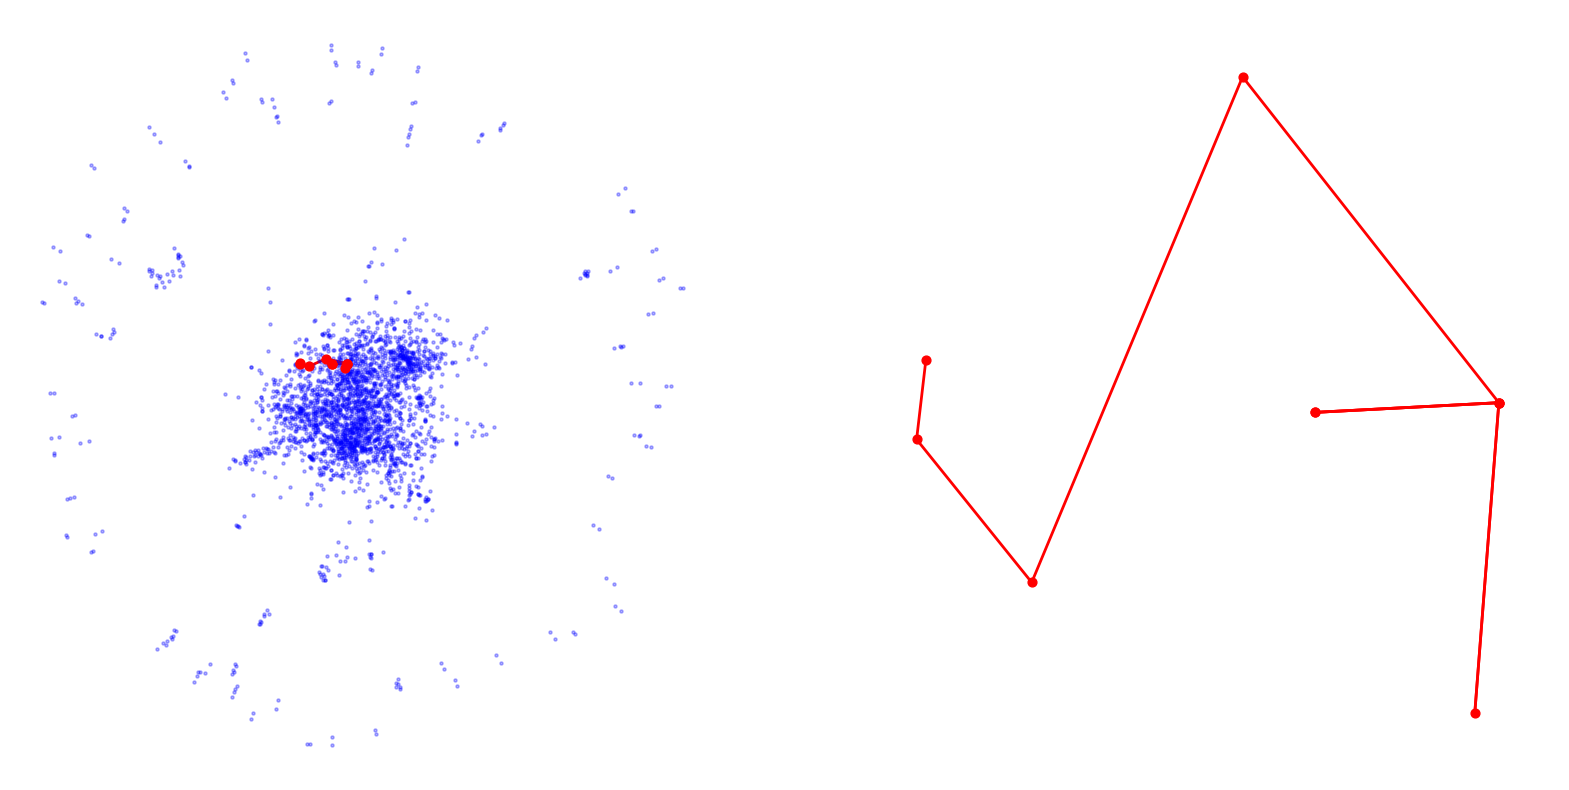

In [14]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

# Training

### Model definition

In [15]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [16]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [17]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [18]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [19]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [20]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

### Training

In [21]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Epoch: 01, Loss: 8.1261, Acc: 0.1760


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 02, Loss: 6.0673, Acc: 0.2090


100%|██████████| 22/22 [00:02<00:00,  8.66it/s]


Epoch: 03, Loss: 4.9491, Acc: 0.2400


100%|██████████| 22/22 [00:02<00:00,  8.66it/s]


Epoch: 04, Loss: 4.1263, Acc: 0.2700


100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


Epoch: 05, Loss: 3.4637, Acc: 0.3100


100%|██████████| 22/22 [00:02<00:00,  8.82it/s]


Epoch: 06, Loss: 2.9570, Acc: 0.3370


100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


Epoch: 07, Loss: 2.5460, Acc: 0.3720


100%|██████████| 22/22 [00:02<00:00,  8.94it/s]


Epoch: 08, Loss: 2.2149, Acc: 0.4110


100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


Epoch: 09, Loss: 1.9544, Acc: 0.4390


100%|██████████| 22/22 [00:02<00:00,  8.80it/s]


Epoch: 10, Loss: 1.7424, Acc: 0.4680


100%|██████████| 22/22 [00:02<00:00,  8.84it/s]


Epoch: 11, Loss: 1.5695, Acc: 0.5010


100%|██████████| 22/22 [00:02<00:00,  8.88it/s]


Epoch: 12, Loss: 1.4329, Acc: 0.5260


100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


Epoch: 13, Loss: 1.3213, Acc: 0.5560


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Epoch: 14, Loss: 1.2335, Acc: 0.5780


100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


Epoch: 15, Loss: 1.1597, Acc: 0.6040


100%|██████████| 22/22 [00:02<00:00,  8.92it/s]


Epoch: 16, Loss: 1.1067, Acc: 0.6170


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 17, Loss: 1.0593, Acc: 0.6340


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 18, Loss: 1.0253, Acc: 0.6460


100%|██████████| 22/22 [00:02<00:00,  8.69it/s]


Epoch: 19, Loss: 0.9982, Acc: 0.6480


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


Epoch: 20, Loss: 0.9750, Acc: 0.6600


100%|██████████| 22/22 [00:02<00:00,  8.52it/s]


Epoch: 21, Loss: 0.9535, Acc: 0.6640


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 22, Loss: 0.9370, Acc: 0.6800


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 23, Loss: 0.9236, Acc: 0.6860


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 24, Loss: 0.9124, Acc: 0.6880


100%|██████████| 22/22 [00:02<00:00,  8.63it/s]


Epoch: 25, Loss: 0.9030, Acc: 0.6900


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 26, Loss: 0.8941, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


Epoch: 27, Loss: 0.8886, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.49it/s]


Epoch: 28, Loss: 0.8813, Acc: 0.6920


100%|██████████| 22/22 [00:02<00:00,  8.48it/s]


Epoch: 29, Loss: 0.8774, Acc: 0.6910


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Epoch: 30, Loss: 0.8719, Acc: 0.6970


100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


Epoch: 31, Loss: 0.8678, Acc: 0.6930


100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


Epoch: 32, Loss: 0.8647, Acc: 0.6960


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


Epoch: 33, Loss: 0.8609, Acc: 0.6910


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 34, Loss: 0.8581, Acc: 0.6960


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 35, Loss: 0.8560, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Epoch: 36, Loss: 0.8527, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.47it/s]


Epoch: 37, Loss: 0.8492, Acc: 0.6970


100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


Epoch: 38, Loss: 0.8488, Acc: 0.6900


100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


Epoch: 39, Loss: 0.8472, Acc: 0.6930


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Epoch: 40, Loss: 0.8451, Acc: 0.6900


100%|██████████| 22/22 [00:02<00:00,  8.62it/s]


Epoch: 41, Loss: 0.8437, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.54it/s]


Epoch: 42, Loss: 0.8435, Acc: 0.7000


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


Epoch: 43, Loss: 0.8408, Acc: 0.6990


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


Epoch: 44, Loss: 0.8402, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 45, Loss: 0.8406, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.68it/s]


Epoch: 46, Loss: 0.8392, Acc: 0.7020


100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


Epoch: 47, Loss: 0.8381, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.49it/s]


Epoch: 48, Loss: 0.8372, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 49, Loss: 0.8373, Acc: 0.7190


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 50, Loss: 0.8350, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.42it/s]


Epoch: 51, Loss: 0.8350, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  7.97it/s]


Epoch: 52, Loss: 0.8333, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.45it/s]


Epoch: 53, Loss: 0.8336, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  8.50it/s]


Epoch: 54, Loss: 0.8334, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.42it/s]


Epoch: 55, Loss: 0.8336, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 56, Loss: 0.8328, Acc: 0.6960


100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Epoch: 57, Loss: 0.8316, Acc: 0.6930


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 58, Loss: 0.8311, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 59, Loss: 0.8308, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 60, Loss: 0.8304, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Epoch: 61, Loss: 0.8293, Acc: 0.7030


100%|██████████| 22/22 [00:02<00:00,  8.62it/s]


Epoch: 62, Loss: 0.8291, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 63, Loss: 0.8292, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


Epoch: 64, Loss: 0.8290, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.46it/s]


Epoch: 65, Loss: 0.8291, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


Epoch: 66, Loss: 0.8281, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Epoch: 67, Loss: 0.8278, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 68, Loss: 0.8275, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 69, Loss: 0.8280, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


Epoch: 70, Loss: 0.8278, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 71, Loss: 0.8268, Acc: 0.7170


100%|██████████| 22/22 [00:02<00:00,  8.63it/s]


Epoch: 72, Loss: 0.8272, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.66it/s]


Epoch: 73, Loss: 0.8275, Acc: 0.7120


100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


Epoch: 74, Loss: 0.8256, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Epoch: 75, Loss: 0.8263, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 76, Loss: 0.8275, Acc: 0.7210


100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


Epoch: 77, Loss: 0.8259, Acc: 0.7240


100%|██████████| 22/22 [00:02<00:00,  8.51it/s]


Epoch: 78, Loss: 0.8259, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.44it/s]


Epoch: 79, Loss: 0.8267, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.51it/s]


Epoch: 80, Loss: 0.8268, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.61it/s]


Epoch: 81, Loss: 0.8255, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 82, Loss: 0.8257, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.61it/s]


Epoch: 83, Loss: 0.8249, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 84, Loss: 0.8249, Acc: 0.7120


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 85, Loss: 0.8253, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.52it/s]


Epoch: 86, Loss: 0.8251, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 87, Loss: 0.8261, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 88, Loss: 0.8263, Acc: 0.7000


100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


Epoch: 89, Loss: 0.8254, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


Epoch: 90, Loss: 0.8251, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.36it/s]


Epoch: 91, Loss: 0.8238, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.55it/s]


Epoch: 92, Loss: 0.8255, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Epoch: 93, Loss: 0.8252, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Epoch: 94, Loss: 0.8256, Acc: 0.7020


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 95, Loss: 0.8253, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 96, Loss: 0.8247, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.49it/s]


Epoch: 97, Loss: 0.8247, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 98, Loss: 0.8264, Acc: 0.7300


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


Epoch: 99, Loss: 0.8241, Acc: 0.7270


100%|██████████| 22/22 [00:02<00:00,  8.37it/s]


Epoch: 100, Loss: 0.8247, Acc: 0.7270


100%|██████████| 22/22 [00:02<00:00,  8.55it/s]


Epoch: 101, Loss: 0.8249, Acc: 0.7210


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 102, Loss: 0.8253, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.61it/s]


Epoch: 103, Loss: 0.8256, Acc: 0.7060


100%|██████████| 22/22 [00:02<00:00,  8.54it/s]


Epoch: 104, Loss: 0.8252, Acc: 0.7120


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Epoch: 105, Loss: 0.8258, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.42it/s]


Epoch: 106, Loss: 0.8248, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.66it/s]


Epoch: 107, Loss: 0.8247, Acc: 0.7170


100%|██████████| 22/22 [00:02<00:00,  8.45it/s]


Epoch: 108, Loss: 0.8246, Acc: 0.7190


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 109, Loss: 0.8245, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Epoch: 110, Loss: 0.8260, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Epoch: 111, Loss: 0.8241, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.69it/s]


Epoch: 112, Loss: 0.8237, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 113, Loss: 0.8246, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 114, Loss: 0.8250, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 115, Loss: 0.8254, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 116, Loss: 0.8247, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 117, Loss: 0.8250, Acc: 0.7190


100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Epoch: 118, Loss: 0.8237, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


Epoch: 119, Loss: 0.8249, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


Epoch: 120, Loss: 0.8243, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  7.58it/s]


Epoch: 121, Loss: 0.8254, Acc: 0.7220


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


Epoch: 122, Loss: 0.8249, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Epoch: 123, Loss: 0.8240, Acc: 0.7170


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 124, Loss: 0.8241, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 125, Loss: 0.8246, Acc: 0.7210


100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


Epoch: 126, Loss: 0.8245, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 127, Loss: 0.8242, Acc: 0.7170


100%|██████████| 22/22 [00:02<00:00,  8.80it/s]


Epoch: 128, Loss: 0.8249, Acc: 0.7350


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 129, Loss: 0.8235, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 130, Loss: 0.8245, Acc: 0.7220


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 131, Loss: 0.8250, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Epoch: 132, Loss: 0.8248, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 133, Loss: 0.8242, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 134, Loss: 0.8239, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 135, Loss: 0.8253, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 136, Loss: 0.8247, Acc: 0.7120


100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


Epoch: 137, Loss: 0.8242, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


Epoch: 138, Loss: 0.8249, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.80it/s]


Epoch: 139, Loss: 0.8257, Acc: 0.7060


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 140, Loss: 0.8254, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 141, Loss: 0.8243, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


Epoch: 142, Loss: 0.8247, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 143, Loss: 0.8254, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 144, Loss: 0.8267, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.80it/s]


Epoch: 145, Loss: 0.8249, Acc: 0.7060


100%|██████████| 22/22 [00:02<00:00,  8.63it/s]


Epoch: 146, Loss: 0.8263, Acc: 0.7030


100%|██████████| 22/22 [00:02<00:00,  8.49it/s]


Epoch: 147, Loss: 0.8236, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 148, Loss: 0.8253, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 149, Loss: 0.8242, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.63it/s]


Epoch: 150, Loss: 0.8253, Acc: 0.7020


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 151, Loss: 0.8243, Acc: 0.6970


100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


Epoch: 152, Loss: 0.8250, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Epoch: 153, Loss: 0.8248, Acc: 0.6940


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 154, Loss: 0.8256, Acc: 0.6890


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 155, Loss: 0.8252, Acc: 0.6910


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 156, Loss: 0.8250, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 157, Loss: 0.8257, Acc: 0.6990


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Epoch: 158, Loss: 0.8258, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.66it/s]


Epoch: 159, Loss: 0.8247, Acc: 0.7140


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 160, Loss: 0.8249, Acc: 0.6850


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 161, Loss: 0.8245, Acc: 0.6890


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 162, Loss: 0.8242, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


Epoch: 163, Loss: 0.8252, Acc: 0.7020


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Epoch: 164, Loss: 0.8246, Acc: 0.7010


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 165, Loss: 0.8238, Acc: 0.6960


100%|██████████| 22/22 [00:02<00:00,  8.82it/s]


Epoch: 166, Loss: 0.8254, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 167, Loss: 0.8222, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.88it/s]


Epoch: 168, Loss: 0.8243, Acc: 0.7150


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 169, Loss: 0.8251, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


Epoch: 170, Loss: 0.8237, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 171, Loss: 0.8244, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 172, Loss: 0.8258, Acc: 0.7160


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 173, Loss: 0.8249, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.75it/s]


Epoch: 174, Loss: 0.8243, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 175, Loss: 0.8251, Acc: 0.7020


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 176, Loss: 0.8248, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.69it/s]


Epoch: 177, Loss: 0.8267, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


Epoch: 178, Loss: 0.8257, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 179, Loss: 0.8253, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.85it/s]


Epoch: 180, Loss: 0.8239, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.77it/s]


Epoch: 181, Loss: 0.8258, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 182, Loss: 0.8249, Acc: 0.7080


100%|██████████| 22/22 [00:02<00:00,  8.68it/s]


Epoch: 183, Loss: 0.8252, Acc: 0.7050


100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


Epoch: 184, Loss: 0.8238, Acc: 0.7100


100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


Epoch: 185, Loss: 0.8251, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


Epoch: 186, Loss: 0.8243, Acc: 0.7070


100%|██████████| 22/22 [00:02<00:00,  8.42it/s]


Epoch: 187, Loss: 0.8238, Acc: 0.7200


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 188, Loss: 0.8252, Acc: 0.7090


100%|██████████| 22/22 [00:02<00:00,  8.49it/s]


Epoch: 189, Loss: 0.8245, Acc: 0.7130


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 190, Loss: 0.8249, Acc: 0.6980


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Epoch: 191, Loss: 0.8248, Acc: 0.6970


100%|██████████| 22/22 [00:02<00:00,  8.54it/s]


Epoch: 192, Loss: 0.8247, Acc: 0.6990


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Epoch: 193, Loss: 0.8258, Acc: 0.7030


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Epoch: 194, Loss: 0.8240, Acc: 0.7040


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch: 195, Loss: 0.8250, Acc: 0.7110


100%|██████████| 22/22 [00:02<00:00,  8.82it/s]


Epoch: 196, Loss: 0.8252, Acc: 0.7120


100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


Epoch: 197, Loss: 0.8251, Acc: 0.7060


100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


Epoch: 198, Loss: 0.8253, Acc: 0.6950


100%|██████████| 22/22 [00:02<00:00,  8.85it/s]


Epoch: 199, Loss: 0.8254, Acc: 0.7000


100%|██████████| 22/22 [00:02<00:00,  8.89it/s]

Epoch: 200, Loss: 0.8247, Acc: 0.6980


### Visualization

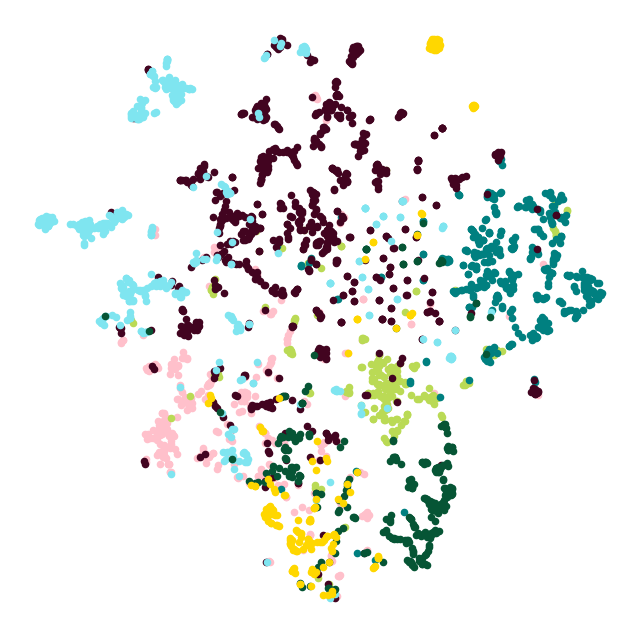

In [22]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)